# Parse Input Midi Files

Analyse Midi files to get the features I am looking for and get a few bars of melody

In [1]:
from music21 import *
from pprint import pprint
from fractions import Fraction


import numpy as np
import glob

In [ ]:
!sudo pip install --upgrade music21

In [ ]:
us = environment.UserSettings()
for key in sorted(us.keys()):
    if key != "localCorpusPath":
        print("Key : ", str(key), "\nValue: ", str(us[key]), "\n")

us["midiPath"] = "/usr/bin/musescore"
us["musicxmlPath"] = "/usr/bin/musescore"
us["musescoreDirectPNGPath"] = "/usr/bin/musescore"
us["lilypondPath"] = "/home/fireredninja/bin/lilypond"

In [ ]:
!ls ./data

In [2]:
!rm ./output/*.mid

In [2]:
# Look at all the functions and attributes
def printAttributesAndFunctions(object):
#     x = True
#     for part in object:
#         if x:
#     #         pprint(dir(note))
#             x = False
    for func in dir(object):
        try:
            f = getattr(object, func)
            print("---------------PASS---------------")
            if callable(f): # is it a function
                # call it
                print(f"PRINTING CALLABLE FUNCTION ----- {func}")
                pprint(eval(f'note.{func}()'), "\n\n\n")
                pass
            else:
                # just print the attribute
                print(f"PRINTING ATTRIBUTE ------ {func}")
                pprint(eval(f'note.{func}'), "\n\n\n")
                pass
        except:
            try:
                pprint(eval(f'note.{func}'), "\n\n\n")
                pass
            except:
                print("---------------FAIL---------------")
                pprint(f'{func}', "\n\n\n")
                pass

In [2]:
def transpose(s):
    k = s.analyze('key')
    print(f"Transposing from {k} to C-major")
    i = interval.Interval(k.tonic, pitch.Pitch('C'))
    sNew = s.transpose(i)
    # do something with sNew
    return sNew

In [3]:
# Checks if the measure contains at least one note and no chords
def metRequirements(measure):
#     pprint("Checking if requirements are met")
    requirementsMet = False
                    
    # Loop through all the notes
    for element in measure.__dict__["_elements"]:
        if isinstance(element, note.Note):
            if checkIfNotesBetween(element, "C4", "C9"):
                requirementsMet = True
            else:
                requirementsMet = False
                break
        elif isinstance(element, note.Rest):
            requirementsMet = True
        elif isinstance(element, chord.Chord):
            requirementsMet = False
#             print("Chord found")
#             print("Requirements not met")
            break

    return requirementsMet

def checkIfNotesBetween(element, note1, note2):
#     print("Note:", element.nameWithOctave)
    if element.pitch.frequency < note.Note(note1).pitch.frequency or element.pitch.frequency > note.Note(note2).pitch.frequency:
#         print("Note not between", note1, "and", note2)
        return False
    return True
    

In [4]:
def getTimeSignature(measure):
    if hasattr(measure, "getElementsByClass"):
        return measure.getElementsByClass(meter.TimeSignature)[0]
    else:
        return None

def checkTimeSignature(measure, tsString):
    timeSignature = getTimeSignature(measure)
    if timeSignature != None:
        if timeSignature.ratioString == tsString:
#             print("Time Signature:", tsString)
            return True
        else:
#             print("Wrong Time Signature Found")
            return False
    else:
#         print("No attribute for TimeSignature")
        pass

In [5]:
def writeToMidi(file, part, partCounter, noOfMeasures):
    try:
#         print(f"generating midi file {file[:-4]}-Part{partCounter}.mid")
        output = stream.Score(id='mainScore')
        filePart = stream.Part(id='part0')
        filePart.append([part.measures(0,noOfMeasures)])
        output.insert(0, filePart)
        # output = transpose(output)
        filename = file[file.rfind("/"):-4] + ".mid"
        output.write(fmt="midi", fp=f"./parsedDataset/{filename}")
    except:
        pass

In [62]:
def readMidi(score, filename):
    # Loop through all the parts in the score
    # each part is the score for an instrument
    try:
#         print("No. of parts ", len(score.parts))
        key = score.analyze('key')
#         print("Key: ", key)
    except:
#         print("Error reading midi file")
        pass
    
    try:
        data = []
        for part in score.parts:
    #         print("----------------NEW PART----------------")
            # Check for nested parts
            if (hasattr(part, "parts")):
                readMidi(part)
            else:
                data += readPart(part)


        data = [x for x in data if x != []]
        
        
#         print("------MIDI START-----")
#         pprint(data)
#         print("------MIDI END-------")
        
        i = 0
        while i < len(data):
            npArr = np.array(data[i], dtype=np.float32)
            saveName = filename[filename.rfind("/")+1:-4] + str(i)
            print(f"Saving {saveName}.npy")
            np.save(f"./numpyRepresentation/{saveName}", npArr)
            print(f" ✔️ : {saveName}.npy was saved")
            i+=1
    except:
        pass
    return
            
            
def readPart(part):
#     try:
#         # exit if the part has less measures than the required amount
#         if (len(part.measures(0, None)) < noOfMeasures):
#             return []
#     except:
#         return []
    
    # holds the measures as a list
    score = []
    
    # parse the file
    if len(part.voices) > 0:
        for voice in part.voices:
            score.append(readVoices(voice))
    else:
        # keeps track of which measure we are on
        measureCounter = 0
        data = []
        for measure in part.measures(0, None):
            
            # go though all measures and see if the key, clef or timesignature has changed
            # exit if it has
            if measureCounter == 0:
                # check if the score/measure uses the correct time signature
                if not checkTimeSignature(measure, '4/4'):
#                     print("TimeSignature not 4/4")
                    break
            if measureCounter > 0 and (measure.__dict__["keyIsNew"] or measure.__dict__["clefIsNew"] or measure.__dict__["timeSignatureIsNew"]):
#                 print("Key/Clef/TimeSignature has changed within the timeframe")
                break
            
            data += readMeasure(measure)
            measureCounter+=1
        score.append(data)
    
    return score


def readVoices(voice):
#     print("-----VOICE--------")
    measureCounter = 0
    data = []
    for measure in voice.measures(0, None):
        # go though all measures and see if the key, clef or timesignature has changed
        # exit if it has
        if measureCounter == 0:
            # check if the score/measure uses the correct time signature
            if not checkTimeSignature(measure, '4/4'):
                break
        elif measureCounter > 0 and (measure.__dict__["keyIsNew"] or measure.__dict__["clefIsNew"] or measure.__dict__["timeSignatureIsNew"]):
            break

    
        data += readMeasure(measure)
        measureCounter+=1
    
#     print("-------Voice-------")
#     pprint(data)
#     print("------------------")
    return data


def readMeasure(measure):
    # loop over all of the measures in the score
#     print("-----MEASURE--------")

    # check if the measure contains a note and doesn't contain chords
    if metRequirements(measure):
#         pprint("Requirements met")
        
        data = measureToList(measure)
#         print("-------MeasureData------")
#         pprint(data)
#         print("------------------------")
        return data
    else:
#         pprint("Requirements not met")
        return []

In [63]:
def createDataset(location):
    # loop through all the midi files in the location
#     data = []
    for file in glob.glob(f"{location}*.mid"):
#         print("----------------NEW FILE----------------")
        midi = converter.parse(file)
        print(f"Parsing {file}")
        
#         scoreData = readMidi(midi, noOfMeasures)
        readMidi(midi, file)
#         if scoreData != []:
#             data += scoreData
    
#     npArr = np.array(data, dtype=np.float32)
#     pprint(npArr)
#     np.save(f"./numpyRepresentation/inputData", npArr)
    print("Finished")
    return

In [64]:
createDataset("./data/")

Parsing ./data/Digimon - Butterfly (Piano Version).mid
Saving Digimon - Butterfly (Piano Version)00.npy
 ✔️ : Digimon - Butterfly (Piano Version)0.npy was saved
Saving Digimon - Butterfly (Piano Version)11.npy
 ✔️ : Digimon - Butterfly (Piano Version)1.npy was saved
Parsing ./data/Pokemon - Farewell, Pikachu!.mid


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 4 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]


Parsing ./data/Pokemon - Lavender town.mid
Saving Pokemon - Lavender town00.npy
 ✔️ : Pokemon - Lavender town0.npy was saved
Parsing ./data/Pokemon - Littleroot Town.mid
Saving Pokemon - Littleroot Town00.npy
 ✔️ : Pokemon - Littleroot Town0.npy was saved
Parsing ./data/Pokemon - Lugias Song.mid
Saving Pokemon - Lugias Song00.npy
 ✔️ : Pokemon - Lugias Song0.npy was saved
Parsing ./data/Pokemon - Oracion.mid
Saving Pokemon - Oracion00.npy
 ✔️ : Pokemon - Oracion0.npy was saved
Parsing ./data/Pokemon - Pallet Town.mid
Parsing ./data/Pokemon - Pkmn Elite 4.mid
Saving Pokemon - Pkmn Elite 400.npy
 ✔️ : Pokemon - Pkmn Elite 40.npy was saved
Parsing ./data/Pokemon - pokecentre theme.mid
Saving Pokemon - pokecentre theme00.npy
 ✔️ : Pokemon - pokecentre theme0.npy was saved
Parsing ./data/Pokemon - Pokemon Center Theme.mid
Saving Pokemon - Pokemon Center Theme00.npy
 ✔️ : Pokemon - Pokemon Center Theme0.npy was saved
Saving Pokemon - Pokemon Center Theme11.npy
 ✔️ : Pokemon - Pokemon Center 

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 1 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]


Parsing ./data/Pokemon Colosseum - Outskirt Stand.mid
Saving Pokemon Colosseum - Outskirt Stand00.npy
 ✔️ : Pokemon Colosseum - Outskirt Stand0.npy was saved
Parsing ./data/Pokemon Colosseum - Pyrite Town.mid
Parsing ./data/Pokemon Colosseum - Relic Forest in Danger.mid
Parsing ./data/Pokemon Colosseum - Relic Forest.mid
Parsing ./data/Pokemon RedBlueYellow - Route 12.mid
Parsing ./data/Pokemon RedBlueYellow - Route 24.mid
Parsing ./data/Pokemon RedBlueYellow - Route 3.mid
Parsing ./data/Pokemon RedBlueYellow - Show Me Around.mid
Parsing ./data/Pokemon RedBlueYellow - Silph Co.mid
Parsing ./data/Pokemon RedBlueYellow - SS Anne.mid
Parsing ./data/Pokemon RedBlueYellow - Surf Theme.mid
Parsing ./data/Pokemon RedBlueYellow - Team Rocket Hideout.mid
Parsing ./data/Pokemon RedBlueYellow - Title Theme.mid
Parsing ./data/Pokemon RedBlueYellow - Trainer Battle.mid
Parsing ./data/Pokemon RedBlueYellow - Vermillion City.mid
Parsing ./data/Pokemon RedBlueYellow - Viridian City.mid
Parsing ./data/

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 6 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/continue>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 6 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continu

Parsing ./data/Pokemon BlackWhite - Castelia City.mid
Parsing ./data/Pokemon BlackWhite - Champion Alder.mid
Parsing ./data/Pokemon BlackWhite - Crisis in Battle.mid
Parsing ./data/Pokemon BlackWhite - Dragonspiral Tower.mid
Parsing ./data/Pokemon BlackWhite - Driftveil City.mid
Parsing ./data/Pokemon BlackWhite - Ending Onward to Our Own Futures.mid


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 3 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 3 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <mus

Parsing ./data/Pokemon BlackWhite - Icirrus City.mid
Parsing ./data/Pokemon GoldSilverCrystal - Union Cave.mid
Parsing ./data/Pokemon GoldSilverCrystal - Victory Road.mid
Parsing ./data/Pokemon GoldSilverCrystal - Violet CityOlivine City.mid


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 6 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/continue>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 6 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.

Parsing ./data/Pokemon HeartGoldSoulSilver - Cerulean City.mid
Saving Pokemon HeartGoldSoulSilver - Cerulean City00.npy
 ✔️ : Pokemon HeartGoldSoulSilver - Cerulean City0.npy was saved
Parsing ./data/Pokemon HeartGoldSoulSilver - Cinnabar Island.mid
Parsing ./data/Pokemon HeartGoldSoulSilver - Game Corner.mid
Parsing ./data/Pokemon HeartGoldSoulSilver - Indigo Plateau.mid
Parsing ./data/Pokemon HeartGoldSoulSilver - Instructions.mid
Parsing ./data/Pokemon HeartGoldSoulSilver - Lyras Theme.mid
Parsing ./data/Pokemon HeartGoldSoulSilver - New Bark Town.mid
Parsing ./data/Pokemon HeartGoldSoulSilver - Pokemaniac Encounter.mid
Parsing ./data/Pokemon XD Gale of Darkness - Mt Battle Lobby.mid
Parsing ./data/Pokemon XD Gale of Darkness - The Hexagon Bros.mid


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 4 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 4 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WAR

Parsing ./data/Pokemon XY - Battle Wild Pokemon.mid
Parsing ./data/Pokemon XY - Bicycle.mid
Parsing ./data/Pokemon XY - Emmas Theme.mid
Parsing ./data/Pokemon XY - FIN.mid
Parsing ./data/Pokemon XY - Route 4567.mid
Parsing ./data/Pokemon XY - The Sycamore Pokemon Lab.mid
Parsing ./data/Pokemon XY - Together with Shauna.mid
Parsing ./data/Pokemon Yellow - Lavender Town (Fixed).mid
Saving Pokemon Yellow - Lavender Town (Fixed)00.npy
 ✔️ : Pokemon Yellow - Lavender Town (Fixed)0.npy was saved
Saving Pokemon Yellow - Lavender Town (Fixed)11.npy
 ✔️ : Pokemon Yellow - Lavender Town (Fixed)1.npy was saved
Parsing ./data/Pokemon.mid
Saving Pokemon00.npy
 ✔️ : Pokemon0.npy was saved
Saving Pokemon11.npy
 ✔️ : Pokemon1.npy was saved
Saving Pokemon22.npy
 ✔️ : Pokemon2.npy was saved
Saving Pokemon33.npy
 ✔️ : Pokemon3.npy was saved
Saving Pokemon44.npy
 ✔️ : Pokemon4.npy was saved
Saving Pokemon55.npy
 ✔️ : Pokemon5.npy was saved
Saving Pokemon66.npy
 ✔️ : Pokemon6.npy was saved
Saving Pokemon77

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 2 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 2 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]


Parsing ./data/Pokemon GoldSilverCrystal - Bicycle.mid
Parsing ./data/Pokemon GoldSilverCrystal - Pokemon March.mid
Parsing ./data/Pokemon GoldSilverCrystal - Title.mid
Parsing ./data/Pokemon HeartGoldSoulSilver - Pokemon Center.mid
Parsing ./data/Pokemon Mystery Dungeon BlueRed Rescue Team - Questionnaire.mid
Parsing ./data/Pokemon Mystery Dungeon Explorers of TimeDarknessSky - Goodnight.mid
Parsing ./data/Pokemon Mystery Dungeon Explorers of TimeDarknessSky - The Gatekeepers.mid
Parsing ./data/Pokemon Pinball - Red Field Theme.mid
Parsing ./data/Pokemon RedBlueYellow - Gym.mid
Parsing ./data/Pokemon RedBlueYellow - Route 1.mid
Parsing ./data/Pokemon RubySapphireEmerald - Desert.mid
Parsing ./data/Pokemon RubySapphireEmerald - Pokemart.mid
Parsing ./data/Pokemon X and Y - Calem and Serena.mid
Parsing ./data/Pokemon RedBlueYellow - Hall of Fame.mid
Parsing ./data/Pokemon RedBlueYellow - Indigo Plateau.mid
Parsing ./data/Pokemon RedBlueYellow - Intro 1.mid
Parsing ./data/Pokemon RedBlue

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 1 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 1 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 1 of 

Parsing ./data/Pokemon BlackWhite - Relic Song.mid


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 2 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 3 of 
[None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]


Parsing ./data/Pokemon BlackWhite - Route 10.mid
Parsing ./data/Pokemon BlackWhite - Route 3.mid
Parsing ./data/Pokemon BlackWhite - Route 4.mid
Parsing ./data/Pokemon GoldSilverCrystal - Bug Catching Contest.mid
Parsing ./data/Pokemon GoldSilverCrystal - Burned Tower.mid
Parsing ./data/Pokemon GoldSilverCrystal - Champion Battle.mid
Parsing ./data/Pokemon GoldSilverCrystal - Cherrygrove CityMahogany Town.mid
Parsing ./data/Pokemon GoldSilverCrystal - Dance Theatre.mid
Parsing ./data/Pokemon GoldSilverCrystal - Dark Cave.mid
Parsing ./data/Pokemon GoldSilverCrystal - Dragons Den.mid
Parsing ./data/Pokemon GoldSilverCrystal - Ecruteak CityCianwood City.mid
Parsing ./data/Pokemon GoldSilverCrystal - Girl Trainer Confrontation.mid
Parsing ./data/Pokemon GoldSilverCrystal - Goldenrod City.mid
Parsing ./data/Pokemon GoldSilverCrystal - Gym Leader Defeated.mid
Parsing ./data/Pokemon GoldSilverCrystal - Gym.mid


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 2 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]


Parsing ./data/Pokemon GoldSilverCrystal - Indigo Plateau.mid
Parsing ./data/Pokemon GoldSilverCrystal - Johto Gym Leader Battle.mid
Parsing ./data/Pokemon GoldSilverCrystal - Johto Wild Pokemon Battle.mid
Parsing ./data/Pokemon GoldSilverCrystal - Kanto Gym Leader Battle.mid
Parsing ./data/Pokemon GoldSilverCrystal - Lavender Town.mid
Parsing ./data/Pokemon GoldSilverCrystal - Menu.mid
Parsing ./data/Pokemon GoldSilverCrystal - National Park.mid
Parsing ./data/Pokemon GoldSilverCrystal - New Bark Town.mid
Parsing ./data/Pokemon GoldSilverCrystal - Olivine Lighthouse.mid
Parsing ./data/Pokemon GoldSilverCrystal - Pokemon Lullaby.mid
Parsing ./data/Pokemon RubySapphireEmerald - Dewford Town.mid
Parsing ./data/Pokemon RubySapphireEmerald - Elite 4 Battle.mid
Parsing ./data/Pokemon RubySapphireEmerald - Ending Theme.mid
Parsing ./data/Pokemon RubySapphireEmerald - Evergrande City.mid
Parsing ./data/Pokemon RubySapphireEmerald - Fallarbor Town.mid
Parsing ./data/Pokemon RubySapphireEmerald

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 4 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/partial/left>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 4 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/partial/left>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Be

Parsing ./data/Pokemon RubySapphireEmerald - Mt Pyre.mid
Parsing ./data/Pokemon RubySapphireEmerald - Oceanic Museum.mid
Parsing ./data/Pokemon RubySapphireEmerald - Oldale Town.mid
Parsing ./data/Pokemon RubySapphireEmerald - Petalburg City.mid
Parsing ./data/Pokemon GoldSilverCrystal - Professor Elms Lab.mid
Parsing ./data/Pokemon GoldSilverCrystal - Professor Oaks Theme.mid
Parsing ./data/Pokemon GoldSilverCrystal - Rival Battle.mid
Parsing ./data/Pokemon GoldSilverCrystal - Route 27.mid
Parsing ./data/Pokemon GoldSilverCrystal - Route 29.mid
Parsing ./data/Pokemon GoldSilverCrystal - Route 32.mid
Parsing ./data/Pokemon GoldSilverCrystal - Route 38.mid
Parsing ./data/Pokemon GoldSilverCrystal - Route 42.mid
Parsing ./data/Pokemon GoldSilverCrystal - Saffron City.mid
Parsing ./data/Pokemon GoldSilverCrystal - Show Me Around.mid
Parsing ./data/Pokemon GoldSilverCrystal - Sprout Tower.mid
Parsing ./data/Pokemon GoldSilverCrystal - Staff Credits.mid
Parsing ./data/Pokemon GoldSilverCrys

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 5 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 5 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <m

Parsing ./data/Pokemon GoldSilverCrystal - Team RocketRadio Tower Takeover.mid
Parsing ./data/Pokemon GoldSilverCrystal - Tin Tower.mid
Parsing ./data/Pokemon Colosseum - The Under.mid
Parsing ./data/Pokemon DiamondPearlPlatinum - Approaching Champion Cynthia.mid
Parsing ./data/Pokemon DiamondPearlPlatinum - Azelf Mesprit and Uxie Battle.mid
Parsing ./data/Pokemon DiamondPearlPlatinum - Battle Champion.mid
Parsing ./data/Pokemon DiamondPearlPlatinum - Battle Rival.mid
Parsing ./data/Pokemon DiamondPearlPlatinum - Battle Team Galactic Admin.mid
Parsing ./data/Pokemon DiamondPearlPlatinum - Battle Trainer.mid
Parsing ./data/Pokemon DiamondPearlPlatinum - Battle Wild Pokemon.mid
Parsing ./data/Pokemon DiamondPearlPlatinum - Canalave City.mid
Parsing ./data/Pokemon DiamondPearlPlatinum - Cyrus  Team Galactic Boss Battle.mid
Parsing ./data/Pokemon DiamondPearlPlatinum - DialgaPalkia Appear.mid
Parsing ./data/Pokemon DiamondPearlPlatinum - Elite Four Battle.mid
Parsing ./data/Pokemon Diamond

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 1 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]


Parsing ./data/Pokemon Ranger - Ranger Base.mid
Parsing ./data/Pokemon RedBlueYellow - Celadon City.mid
Parsing ./data/Pokemon RedBlueYellow - Cerulean City.mid
Parsing ./data/Pokemon RedBlueYellow - Champion Battle.mid
Parsing ./data/Pokemon RedBlueYellow - Cinnabar Island.mid
Parsing ./data/Pokemon RedBlueYellow - Cycling.mid
Parsing ./data/Pokemon RedBlueYellow - Elite Four.mid
Parsing ./data/Pokemon RedBlueYellow - Ending Theme.mid
Parsing ./data/Pokemon RedBlueYellow - Evolution.mid
Parsing ./data/Pokemon RedBlueYellow - Game Corner Theme.mid
Parsing ./data/Pokemon RedBlueYellow - Gym Leader Battle.mid


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 4 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 4 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.

Parsing ./data/Pokemon RubySapphireEmerald - Pokemon Contest.mid
Parsing ./data/Pokemon RubySapphireEmerald - Recovery.mid
Parsing ./data/Pokemon RubySapphireEmerald - Rival Battle.mid
Parsing ./data/Pokemon RubySapphireEmerald - Route 101.mid
Parsing ./data/Pokemon RubySapphireEmerald - Route 104.mid
Parsing ./data/Pokemon RubySapphireEmerald - Route 110.mid
Parsing ./data/Pokemon RubySapphireEmerald - Route 111 Desert.mid
Parsing ./data/Pokemon RubySapphireEmerald - Route 120.mid
Parsing ./data/Pokemon RubySapphireEmerald - Slateport City.mid
Parsing ./data/Pokemon RubySapphireEmerald - Sootopolis City.mid


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 3 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 1 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/

Parsing ./data/Pokemon RubySapphireEmerald - Surfing.mid
Parsing ./data/Pokemon RubySapphireEmerald - Trainers School.mid
Parsing ./data/Pokemon RubySapphireEmerald - Trick House.mid
Parsing ./data/Pokemon RubySapphireEmerald - Verdanturf Town.mid
Parsing ./data/Pokemon RubySapphireEmerald - Wild Pokemon Battle.mid
Parsing ./data/Pokemon RubySapphireEmerald - Wild Pokemon Caught or Fainted.mid
Parsing ./data/Pokemon Snap - A Mysterious Sighting.mid
Parsing ./data/Pokemon Snap - Snapshot Lullaby.mid
Parsing ./data/Pokemon Trading Card Game - Title Screen.mid
Parsing ./data/Pokemon DiamondPearlPlatinum - Old Chateau.mid
Parsing ./data/Pokemon DiamondPearlPlatinum - Pokemon League Day.mid
Parsing ./data/Pokemon DiamondPearlPlatinum - Poketch Addition.mid
Parsing ./data/Pokemon DiamondPearlPlatinum - Research Lab.mid
Parsing ./data/Pokemon DiamondPearlPlatinum - Route 202.mid
Parsing ./data/Pokemon DiamondPearlPlatinum - Route 205 Night.mid
Parsing ./data/Pokemon DiamondPearlPlatinum - Rou

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 7 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 6 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2

Parsing ./data/Pokemon Mystery Dungeon BlueRed Rescue Team - Monster House.mid
Parsing ./data/Pokemon Mystery Dungeon BlueRed Rescue Team - Parting.mid
Parsing ./data/Pokemon DiamondPearlPlatinum - Spear Pillar.mid
Parsing ./data/Pokemon DiamondPearlPlatinum - Stark Mountain.mid
Parsing ./data/Pokemon DiamondPearlPlatinum - Team Galactic Grunt Battle.mid
Parsing ./data/Pokemon DiamondPearlPlatinum - Torn WorldDistortion World.mid
Parsing ./data/Pokemon DiamondPearlPlatinum - Twinleaf Town Day.mid
Parsing ./data/Pokemon DiamondPearlPlatinum - Veilstone City.mid
Parsing ./data/Pokemon DiamondPearlPlatinum - Villa  Twinleaf Music Box.mid
Parsing ./data/Pokemon DiamondPearlPlatinum - WiFi Lobby.mid
Parsing ./data/Pokemon Gold, Silver, Crystal - Cinnabar Island (HGSS Version).mid
Parsing ./data/Pokemon Gold, Silver, Crystal - S.S. Aqua .mid
Parsing ./data/Pokemon GoldSilverCrystal - Azalea TownBlackthorn City.mid
Parsing ./data/Pokemon Mystery Dungeon BlueRed Rescue Team - Rescue Team Base.

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 12 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/continue>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<mus

Parsing ./data/Pokemon Mystery Dungeon BlueRed Rescue Team - Sky Tower.mid


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 11 of 
[None, None, None, None, None, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 27 of 
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]


Parsing ./data/Pokemon Mystery Dungeon BlueRed Rescue Team - Tiny Woods.mid
Parsing ./data/Pokemon Mystery Dungeon BlueRed Rescue Team - Title Screen.mid
Parsing ./data/Pokemon Mystery Dungeon Explorers of TimeDarknessSky - A Sinister Smell Team Skulls Theme.mid
Parsing ./data/Pokemon Mystery Dungeon Explorers of TimeDarknessSky - A Wish For Peace.mid
Parsing ./data/Pokemon Mystery Dungeon Explorers of TimeDarknessSky - Aegis Cave.mid
Parsing ./data/Pokemon Mystery Dungeon Explorers of TimeDarknessSky - Amp Plains.mid
Parsing ./data/Pokemon Mystery Dungeon Explorers of TimeDarknessSky - Apple Woods.mid
Parsing ./data/Pokemon Mystery Dungeon Explorers of TimeDarknessSky - At the End of the Day.mid
Parsing ./data/Pokemon Mystery Dungeon Explorers of TimeDarknessSky - Defend Globe.mid
Parsing ./data/Pokemon Mystery Dungeon Explorers of TimeDarknessSky - Drenched Bluff.mid
Parsing ./data/Pokemon Mystery Dungeon Explorers of TimeDarknessSky - Dusk Forest.mid
Parsing ./data/Pokemon Mystery D

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 8 of 
[None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/continue>>, <music21.beam.Beams <music21.beam.Beam 1/partial/left>/<music21.beam.Beam 2/stop>>, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 8 of 
[None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music

Parsing ./data/Pokemon Mystery Dungeon Explorers of TimeDarknessSky - Heartwarming.mid


meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 6 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 6 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>

Parsing ./data/Pokemon Mystery Dungeon Explorers of TimeDarknessSky - Hidden Highland.mid
Parsing ./data/Pokemon Mystery Dungeon Explorers of TimeDarknessSky - Hidden Land.mid
Parsing ./data/Pokemon Mystery Dungeon Explorers of TimeDarknessSky - I Dont Want to Say Goodbye.mid
Parsing ./data/Pokemon Mystery Dungeon Explorers of TimeDarknessSky - In the Hands of Fate.mid
Parsing ./data/Pokemon Mystery Dungeon Explorers of TimeDarknessSky - Lower Brine Cave.mid
Parsing ./data/Pokemon Mystery Dungeon Explorers of TimeDarknessSky - Oh No.mid
Parsing ./data/Pokemon Mystery Dungeon Explorers of TimeDarknessSky - Palkias Onslaught.mid
Parsing ./data/Pokemon Mystery Dungeon Explorers of TimeDarknessSky - Pelippers Island.mid
Parsing ./data/Pokemon Mystery Dungeon Explorers of TimeDarknessSky - Sealed Ruin Pit.mid
Parsing ./data/Pokemon Mystery Dungeon Explorers of TimeDarknessSky - Sky Peak Final Pass.mid
Parsing ./data/Pokemon Mystery Dungeon Explorers of TimeDarknessSky - Spacial Cliffs.mid
P

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 4 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 4 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.

Parsing ./data/Pokemon Pinball - Catch Em and Evolution Mode in Red Field.mid
Parsing ./data/Pokemon Pinball - Field Select.mid
Parsing ./data/Pokemon Pinball - Pokedex.mid
Finished


In [65]:
npArr = np.load("./numpyRepresentation/Digimon - Butterfly (Piano Version)0.npy")
pprint(npArr)

array([[0.36199096, 0.25      ],
       [0.3846154 , 0.25      ],
       [0.3846154 , 0.5       ],
       [0.3846154 , 0.25      ],
       [0.3846154 , 1.        ],
       [0.36199096, 0.5       ],
       [0.39366516, 0.5       ],
       [0.3846154 , 1.        ],
       [0.33936653, 0.25      ],
       [0.36199096, 0.5       ],
       [0.36199096, 0.5       ],
       [0.3846154 , 0.25      ],
       [0.3846154 , 0.5       ],
       [0.3846154 , 0.25      ],
       [0.3846154 , 1.        ],
       [0.36199096, 0.5       ],
       [0.39366516, 0.5       ],
       [0.4117647 , 1.        ],
       [0.35746607, 0.5       ],
       [0.3484163 , 0.5       ],
       [0.35746607, 0.5       ],
       [0.3484163 , 0.5       ],
       [0.33936653, 1.5       ],
       [0.33936653, 0.25      ],
       [0.33936653, 0.25      ],
       [0.35746607, 0.5       ],
       [0.35746607, 0.5       ],
       [0.3484163 , 0.25      ],
       [0.33936653, 0.25      ],
       [0.37104073, 1.        ],
       [0.

In [63]:
npArr = np.array(data, dtype=np.float64)

ValueError: setting an array element with a sequence.

In [64]:
print(npArr)

[list([[0.31221719457013575, 0.5], [0.37104072398190047, 0.5], [0.31221719457013575, 0.5], [0.31221719457013575, 0.5], [0.37104072398190047, 0.5], [0.31221719457013575, 0.5], [0.3393665158371041, 0.5], [0.3891402714932127, 0.5], [0.3393665158371041, 0.5]])
 list([[0.416289592760181, 1.0], [0.4343891402714932, 1.0], [0.4253393665158371, 1.25], [0.40271493212669685, 0.5], [0.416289592760181, 0.25], [0.416289592760181, 0.25], [0.38461538461538464, 3.0], [0.416289592760181, 0.75]])
 list([[0.3891402714932127, 1.0], [0.40271493212669685, 1.0], [0.416289592760181, 1.0], [0.46153846153846156, 1.0], [0.4479638009049774, 4.0]])
 list([[0.40271493212669685, 0.5], [0.37104072398190047, 0.5], [0.40271493212669685, 0.5], [0.4479638009049774, 1.0], [0.4343891402714932, 1.0], [0.4253393665158371, 0.5], [0.416289592760181, 0.5], [0.3936651583710407, 3.5]])
 list([[0.40271493212669685, 0.5], [0.37104072398190047, 0.5], [0.40271493212669685, 0.5], [0.4479638009049774, 1.0], [0.4343891402714932, 0.5], [0

# Midi to Numpy

Create a numpy representation of the midi files for the Deep Learning model

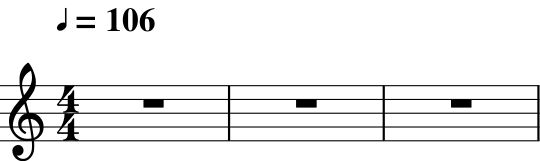

In [15]:
midi = converter.parse("./data/Digimon - Butterfly (Piano Version).mid")
midi.measures(0,3).parts[0].show()

In [88]:
# part = midi.parts[0]
# for measure in part.measures(0, None):
#     pprint(measure.__dict__["keyIsNew"])

rest = note.Note('C6')
pprint(rest.nameWithOctave)

'C6'


In [8]:
# -------------MAIN FUNCTION--------------------
def midiToNetworkInput(midi):
    notes = getNotes(midi)
    return createNetworkInput(notes)

def partToNetworkInput(part):
    notes = getNotesFromPart(part)
    pprint(notes)
    return createNetworkInput(notes)

def measureToList(measure):
    notes = getNotes(measure)
    return createNetworkInput(notes)
    
    

# -------------HELPER FUNCTIONS-----------------
def noteToFloat(note):
    note_to_float = {'rest': 0.0, 'C0': 0.004524886877828055, 'C#0': 0.00904977375565611, 'D-0': 0.013574660633484163, 'D0': 0.01809954751131222, 'D#0': 0.02262443438914027, 'E-0': 0.027149321266968326, 'E0': 0.03167420814479638, 'F0': 0.03619909502262444, 'F#0': 0.04072398190045249, 'G-0': 0.04524886877828054, 'G0': 0.049773755656108594, 'G#0': 0.05429864253393665, 'A-0': 0.058823529411764705, 'A0': 0.06334841628959276, 'A#0': 0.06787330316742081, 'B-0': 0.07239819004524888, 'B0': 0.07692307692307693, 'C1': 0.08144796380090498, 'C#1': 0.08597285067873303, 'D-1': 0.09049773755656108, 'D1': 0.09502262443438914, 'D#1': 0.09954751131221719, 'E-1': 0.10407239819004525, 'E1': 0.1085972850678733, 'F1': 0.11312217194570136, 'F#1': 0.11764705882352941, 'G-1': 0.12217194570135746, 'G1': 0.12669683257918551, 'G#1': 0.13122171945701358, 'A-1': 0.13574660633484162, 'A1': 0.14027149321266968, 'A#1': 0.14479638009049775, 'B-1': 0.1493212669683258, 'B1': 0.15384615384615385, 'C2': 0.1583710407239819, 'C#2': 0.16289592760180996, 'D-2': 0.167420814479638, 'D2': 0.17194570135746606, 'D#2': 0.17647058823529413, 'E-2': 0.18099547511312217, 'E2': 0.18552036199095023, 'F2': 0.19004524886877827, 'F#2': 0.19457013574660634, 'G-2': 0.19909502262443438, 'G2': 0.20361990950226244, 'G#2': 0.2081447963800905, 'A-2': 0.21266968325791855, 'A2': 0.2171945701357466, 'A#2': 0.22171945701357465, 'B-2': 0.22624434389140272, 'B2': 0.23076923076923078, 'C3': 0.23529411764705882, 'C#3': 0.2398190045248869, 'D-3': 0.24434389140271492, 'D3': 0.248868778280543, 'D#3': 0.25339366515837103, 'E-3': 0.2579185520361991, 'E3': 0.26244343891402716, 'F3': 0.2669683257918552, 'F#3': 0.27149321266968324, 'G-3': 0.27601809954751133, 'G3': 0.28054298642533937, 'G#3': 0.2850678733031674, 'A-3': 0.2895927601809955, 'A3': 0.29411764705882354, 'A#3': 0.2986425339366516, 'B-3': 0.3031674208144796, 'B3': 0.3076923076923077, 'C4': 0.31221719457013575, 'C#4': 0.3167420814479638, 'D-4': 0.3212669683257919, 'D4': 0.3257918552036199, 'D#4': 0.33031674208144796, 'E-4': 0.334841628959276, 'E4': 0.3393665158371041, 'F4': 0.3438914027149321, 'F#4': 0.34841628959276016, 'G-4': 0.35294117647058826, 'G4': 0.3574660633484163, 'G#4': 0.36199095022624433, 'A-4': 0.3665158371040724, 'A4': 0.37104072398190047, 'A#4': 0.3755656108597285, 'B-4': 0.38009049773755654, 'B4': 0.38461538461538464, 'C5': 0.3891402714932127, 'C#5': 0.3936651583710407, 'D-5': 0.39819004524886875, 'D5': 0.40271493212669685, 'D#5': 0.4072398190045249, 'E-5': 0.4117647058823529, 'E5': 0.416289592760181, 'F5': 0.42081447963800905, 'F#5': 0.4253393665158371, 'G-5': 0.4298642533936652, 'G5': 0.4343891402714932, 'G#5': 0.43891402714932126, 'A-5': 0.4434389140271493, 'A5': 0.4479638009049774, 'A#5': 0.45248868778280543, 'B-5': 0.45701357466063347, 'B5': 0.46153846153846156, 'C6': 0.4660633484162896, 'C#6': 0.47058823529411764, 'D-6': 0.4751131221719457, 'D6': 0.4796380090497738, 'D#6': 0.4841628959276018, 'E-6': 0.48868778280542985, 'E6': 0.49321266968325794, 'F6': 0.497737556561086, 'F#6': 0.502262443438914, 'G-6': 0.5067873303167421, 'G6': 0.5113122171945701, 'G#6': 0.5158371040723982, 'A-6': 0.5203619909502263, 'A6': 0.5248868778280543, 'A#6': 0.5294117647058824, 'B-6': 0.5339366515837104, 'B6': 0.5384615384615384, 'C7': 0.5429864253393665, 'C#7': 0.5475113122171946, 'D-7': 0.5520361990950227, 'D7': 0.5565610859728507, 'D#7': 0.5610859728506787, 'E-7': 0.5656108597285068, 'E7': 0.5701357466063348, 'F7': 0.5746606334841629, 'F#7': 0.579185520361991, 'G-7': 0.583710407239819, 'G7': 0.5882352941176471, 'G#7': 0.5927601809954751, 'A-7': 0.5972850678733032, 'A7': 0.6018099547511312, 'A#7': 0.6063348416289592, 'B-7': 0.6108597285067874, 'B7': 0.6153846153846154, 'C8': 0.6199095022624435, 'C#8': 0.6244343891402715, 'D-8': 0.6289592760180995, 'D8': 0.6334841628959276, 'D#8': 0.6380090497737556, 'E-8': 0.6425339366515838, 'E8': 0.6470588235294118, 'F8': 0.6515837104072398, 'F#8': 0.6561085972850679, 'G-8': 0.6606334841628959, 'G8': 0.665158371040724, 'G#8': 0.669683257918552, 'A-8': 0.6742081447963801, 'A8': 0.6787330316742082, 'A#8': 0.6832579185520362, 'B-8': 0.6877828054298643, 'B8': 0.6923076923076923, 'C9': 0.6968325791855203, 'C#9': 0.7013574660633484, 'D-9': 0.7058823529411765, 'D9': 0.7104072398190046, 'D#9': 0.7149321266968326, 'E-9': 0.7194570135746606, 'E9': 0.7239819004524887, 'F9': 0.7285067873303167, 'F#9': 0.7330316742081447, 'G-9': 0.7375565610859729, 'G9': 0.7420814479638009, 'G#9': 0.746606334841629, 'A-9': 0.751131221719457, 'A9': 0.755656108597285, 'A#9': 0.7601809954751131, 'B-9': 0.7647058823529411, 'B9': 0.7692307692307693, 'C10': 0.7737556561085973, 'C#10': 0.7782805429864253, 'D-10': 0.7828054298642534, 'D10': 0.7873303167420814, 'D#10': 0.7918552036199095, 'E-10': 0.7963800904977375, 'E10': 0.8009049773755657, 'F10': 0.8054298642533937, 'F#10': 0.8099547511312217, 'G-10': 0.8144796380090498, 'G10': 0.8190045248868778, 'G#10': 0.8235294117647058, 'A-10': 0.8280542986425339, 'A10': 0.832579185520362, 'A#10': 0.8371040723981901, 'B-10': 0.8416289592760181, 'B10': 0.8461538461538461, 'C11': 0.8506787330316742, 'C#11': 0.8552036199095022, 'D-11': 0.8597285067873304, 'D11': 0.8642533936651584, 'D#11': 0.8687782805429864, 'E-11': 0.8733031674208145, 'E11': 0.8778280542986425, 'F11': 0.8823529411764706, 'F#11': 0.8868778280542986, 'G-11': 0.8914027149321267, 'G11': 0.8959276018099548, 'G#11': 0.9004524886877828, 'A-11': 0.9049773755656109, 'A11': 0.9095022624434389, 'A#11': 0.9140271493212669, 'B-11': 0.918552036199095, 'B11': 0.9230769230769231, 'C12': 0.9276018099547512, 'C#12': 0.9321266968325792, 'D-12': 0.9366515837104072, 'D12': 0.9411764705882353, 'D#12': 0.9457013574660633, 'E-12': 0.9502262443438914, 'E12': 0.9547511312217195, 'F12': 0.9592760180995475, 'F#12': 0.9638009049773756, 'G-12': 0.9683257918552036, 'G12': 0.9728506787330317, 'G#12': 0.9773755656108597, 'A-12': 0.9819004524886877, 'A12': 0.9864253393665159, 'A#12': 0.9909502262443439, 'B-12': 0.995475113122172, 'B12': 1.0}
    return note_to_float[note]

def getDuration(note):
    duration = note.duration.quarterLength
    if isinstance(duration, Fraction):
        return duration.numerator/duration.denominator # used to be round(duration.numerator/duration.denominator, 3)
    else:
        return duration

def createNetworkInput(notes):
    network_input = []
    for element in notes:
        if element.isRest:
            
            network_input.append([noteToFloat(element.name), getDuration(element)])
        if element.isNote:
            network_input.append([noteToFloat(element.nameWithOctave), getDuration(element)])
    return network_input

def getNotes(midi):
    part = midi.notes
#     part = midi.__dict__["_elements"][0].__dict__["_elements"]
    return [element for element in part if isinstance(element, note.GeneralNote)]

def getNotesFromPart(part):
    partElements = midi.__dict__["_elements"]
    return [element for element in partElements if isinstance(element, note.GeneralNote)]

def normalise(value):
    return (value-0)/(221-0)

In [86]:
!rm ./numpyRepresentation/*

In [12]:
for file in glob.glob('./parsedDataset/*.mid'):
    midi = converter.parse(file)
    npArr = midiToNetworkInput(midi)
    filename = file[file.rfind("/"):-4]
    pprint(file)
    pprint(npArr.shape)
    pprint(npArr)
#     if len(npArr) > 0:
#         np.save(f"./numpyRepresentation/{filename}", npArr)

'./parsedDataset/PokemonColosseum-SemifinalBattle.mid'
(0,)
array([], dtype=float64)
'./parsedDataset/Pokemon-LittlerootTown.mid'
(20, 2)
array([[0.        , 0.5       ],
       [0.31221719, 0.5       ],
       [0.37104072, 0.5       ],
       [0.31221719, 0.5       ],
       [0.        , 2.        ],
       [0.31221719, 0.5       ],
       [0.37104072, 0.5       ],
       [0.31221719, 0.5       ],
       [0.        , 0.5       ],
       [0.33936652, 0.5       ],
       [0.38914027, 0.5       ],
       [0.33936652, 0.5       ],
       [0.        , 0.5       ],
       [0.31221719, 0.5       ],
       [0.37104072, 0.5       ],
       [0.35746606, 0.5       ],
       [0.        , 0.5       ],
       [0.37104072, 0.5       ],
       [0.42081448, 0.5       ],
       [0.37104072, 0.5       ]])
'./parsedDataset/Pokemon-LugiasSong.mid'
(12, 2)
array([[0.41628959, 1.        ],
       [0.43438914, 1.        ],
       [0.42533937, 1.25      ],
       [0.40271493, 0.5       ],
       [0.41628959, 

# Numpy to Midi

Using numpy arrays from the format from before passing through the model, turn it into midi

In [93]:
def numpyArrToMidi(npArr, filename):
    output = stream.Score(id='mainScore')
    filePart = stream.Part(id='part0')
    for note in npArr:
        noteString = floatToNoteName(note[0])
        noteObject = getNote(noteString, note[1])
        filePart.append(noteObject)
    output.insert(0, filePart)
    filename = file[file.rfind("/"):-4] + ".mid"
    output.write(fmt="midi", fp=f"./output/{filename}")

def getNote(noteString, duration):
    if noteString != 'rest':
        noteObject = note.Note(noteString)
        
#         if duration ==
        noteObject.duration.quarterLength = duration
        return noteObject
    else:
        return note.Rest()
    
def floatToNoteName(value):
    note_to_float = {'rest': 0.0, 'C0': 0.004524886877828055, 'C#0': 0.00904977375565611, 'D-0': 0.013574660633484163, 'D0': 0.01809954751131222, 'D#0': 0.02262443438914027, 'E-0': 0.027149321266968326, 'E0': 0.03167420814479638, 'F0': 0.03619909502262444, 'F#0': 0.04072398190045249, 'G-0': 0.04524886877828054, 'G0': 0.049773755656108594, 'G#0': 0.05429864253393665, 'A-0': 0.058823529411764705, 'A0': 0.06334841628959276, 'A#0': 0.06787330316742081, 'B-0': 0.07239819004524888, 'B0': 0.07692307692307693, 'C1': 0.08144796380090498, 'C#1': 0.08597285067873303, 'D-1': 0.09049773755656108, 'D1': 0.09502262443438914, 'D#1': 0.09954751131221719, 'E-1': 0.10407239819004525, 'E1': 0.1085972850678733, 'F1': 0.11312217194570136, 'F#1': 0.11764705882352941, 'G-1': 0.12217194570135746, 'G1': 0.12669683257918551, 'G#1': 0.13122171945701358, 'A-1': 0.13574660633484162, 'A1': 0.14027149321266968, 'A#1': 0.14479638009049775, 'B-1': 0.1493212669683258, 'B1': 0.15384615384615385, 'C2': 0.1583710407239819, 'C#2': 0.16289592760180996, 'D-2': 0.167420814479638, 'D2': 0.17194570135746606, 'D#2': 0.17647058823529413, 'E-2': 0.18099547511312217, 'E2': 0.18552036199095023, 'F2': 0.19004524886877827, 'F#2': 0.19457013574660634, 'G-2': 0.19909502262443438, 'G2': 0.20361990950226244, 'G#2': 0.2081447963800905, 'A-2': 0.21266968325791855, 'A2': 0.2171945701357466, 'A#2': 0.22171945701357465, 'B-2': 0.22624434389140272, 'B2': 0.23076923076923078, 'C3': 0.23529411764705882, 'C#3': 0.2398190045248869, 'D-3': 0.24434389140271492, 'D3': 0.248868778280543, 'D#3': 0.25339366515837103, 'E-3': 0.2579185520361991, 'E3': 0.26244343891402716, 'F3': 0.2669683257918552, 'F#3': 0.27149321266968324, 'G-3': 0.27601809954751133, 'G3': 0.28054298642533937, 'G#3': 0.2850678733031674, 'A-3': 0.2895927601809955, 'A3': 0.29411764705882354, 'A#3': 0.2986425339366516, 'B-3': 0.3031674208144796, 'B3': 0.3076923076923077, 'C4': 0.31221719457013575, 'C#4': 0.3167420814479638, 'D-4': 0.3212669683257919, 'D4': 0.3257918552036199, 'D#4': 0.33031674208144796, 'E-4': 0.334841628959276, 'E4': 0.3393665158371041, 'F4': 0.3438914027149321, 'F#4': 0.34841628959276016, 'G-4': 0.35294117647058826, 'G4': 0.3574660633484163, 'G#4': 0.36199095022624433, 'A-4': 0.3665158371040724, 'A4': 0.37104072398190047, 'A#4': 0.3755656108597285, 'B-4': 0.38009049773755654, 'B4': 0.38461538461538464, 'C5': 0.3891402714932127, 'C#5': 0.3936651583710407, 'D-5': 0.39819004524886875, 'D5': 0.40271493212669685, 'D#5': 0.4072398190045249, 'E-5': 0.4117647058823529, 'E5': 0.416289592760181, 'F5': 0.42081447963800905, 'F#5': 0.4253393665158371, 'G-5': 0.4298642533936652, 'G5': 0.4343891402714932, 'G#5': 0.43891402714932126, 'A-5': 0.4434389140271493, 'A5': 0.4479638009049774, 'A#5': 0.45248868778280543, 'B-5': 0.45701357466063347, 'B5': 0.46153846153846156, 'C6': 0.4660633484162896, 'C#6': 0.47058823529411764, 'D-6': 0.4751131221719457, 'D6': 0.4796380090497738, 'D#6': 0.4841628959276018, 'E-6': 0.48868778280542985, 'E6': 0.49321266968325794, 'F6': 0.497737556561086, 'F#6': 0.502262443438914, 'G-6': 0.5067873303167421, 'G6': 0.5113122171945701, 'G#6': 0.5158371040723982, 'A-6': 0.5203619909502263, 'A6': 0.5248868778280543, 'A#6': 0.5294117647058824, 'B-6': 0.5339366515837104, 'B6': 0.5384615384615384, 'C7': 0.5429864253393665, 'C#7': 0.5475113122171946, 'D-7': 0.5520361990950227, 'D7': 0.5565610859728507, 'D#7': 0.5610859728506787, 'E-7': 0.5656108597285068, 'E7': 0.5701357466063348, 'F7': 0.5746606334841629, 'F#7': 0.579185520361991, 'G-7': 0.583710407239819, 'G7': 0.5882352941176471, 'G#7': 0.5927601809954751, 'A-7': 0.5972850678733032, 'A7': 0.6018099547511312, 'A#7': 0.6063348416289592, 'B-7': 0.6108597285067874, 'B7': 0.6153846153846154, 'C8': 0.6199095022624435, 'C#8': 0.6244343891402715, 'D-8': 0.6289592760180995, 'D8': 0.6334841628959276, 'D#8': 0.6380090497737556, 'E-8': 0.6425339366515838, 'E8': 0.6470588235294118, 'F8': 0.6515837104072398, 'F#8': 0.6561085972850679, 'G-8': 0.6606334841628959, 'G8': 0.665158371040724, 'G#8': 0.669683257918552, 'A-8': 0.6742081447963801, 'A8': 0.6787330316742082, 'A#8': 0.6832579185520362, 'B-8': 0.6877828054298643, 'B8': 0.6923076923076923, 'C9': 0.6968325791855203, 'C#9': 0.7013574660633484, 'D-9': 0.7058823529411765, 'D9': 0.7104072398190046, 'D#9': 0.7149321266968326, 'E-9': 0.7194570135746606, 'E9': 0.7239819004524887, 'F9': 0.7285067873303167, 'F#9': 0.7330316742081447, 'G-9': 0.7375565610859729, 'G9': 0.7420814479638009, 'G#9': 0.746606334841629, 'A-9': 0.751131221719457, 'A9': 0.755656108597285, 'A#9': 0.7601809954751131, 'B-9': 0.7647058823529411, 'B9': 0.7692307692307693, 'C10': 0.7737556561085973, 'C#10': 0.7782805429864253, 'D-10': 0.7828054298642534, 'D10': 0.7873303167420814, 'D#10': 0.7918552036199095, 'E-10': 0.7963800904977375, 'E10': 0.8009049773755657, 'F10': 0.8054298642533937, 'F#10': 0.8099547511312217, 'G-10': 0.8144796380090498, 'G10': 0.8190045248868778, 'G#10': 0.8235294117647058, 'A-10': 0.8280542986425339, 'A10': 0.832579185520362, 'A#10': 0.8371040723981901, 'B-10': 0.8416289592760181, 'B10': 0.8461538461538461, 'C11': 0.8506787330316742, 'C#11': 0.8552036199095022, 'D-11': 0.8597285067873304, 'D11': 0.8642533936651584, 'D#11': 0.8687782805429864, 'E-11': 0.8733031674208145, 'E11': 0.8778280542986425, 'F11': 0.8823529411764706, 'F#11': 0.8868778280542986, 'G-11': 0.8914027149321267, 'G11': 0.8959276018099548, 'G#11': 0.9004524886877828, 'A-11': 0.9049773755656109, 'A11': 0.9095022624434389, 'A#11': 0.9140271493212669, 'B-11': 0.918552036199095, 'B11': 0.9230769230769231, 'C12': 0.9276018099547512, 'C#12': 0.9321266968325792, 'D-12': 0.9366515837104072, 'D12': 0.9411764705882353, 'D#12': 0.9457013574660633, 'E-12': 0.9502262443438914, 'E12': 0.9547511312217195, 'F12': 0.9592760180995475, 'F#12': 0.9638009049773756, 'G-12': 0.9683257918552036, 'G12': 0.9728506787330317, 'G#12': 0.9773755656108597, 'A-12': 0.9819004524886877, 'A12': 0.9864253393665159, 'A#12': 0.9909502262443439, 'B-12': 0.995475113122172, 'B12': 1.0}
    return list(note_to_float.keys())[list(note_to_float.values()).index(value)]


In [91]:
!rm ./output/*

rm: cannot remove './output/*': No such file or directory


In [ ]:
for file in glob.glob('./numpyRepresentation/*.npy'):
    arr = np.load(file)
    filename = file[file.rfind("/")+1:-4]
    numpyArrToMidi(arr, filename)